In [ ]:
#!pip install qiskit

In [ ]:
#!pip install qiskit-aer qiskit-ibm-runtime

In [ ]:
#!pip install iqm-benchmarks

In [ ]:
#!pip install iqm-client[qiskit]

In [17]:
from iqm.iqm_client.models import CircuitCompilationOptions
from iqm.iqm_client.models import DDMode, DDStrategy

from iqm import qiskit_iqm
from iqm.qiskit_iqm import IQMProvider
from iqm.benchmarks.readout_mitigation import apply_readout_error_mitigation

In [18]:
server_url = "https://cocos.resonance.meetiqm.com/garnet"
provider = IQMProvider(server_url, token="GZm9VeCRVDjClWxK9BXu/4vFJtqEpwniUYtjBwio7s0GiY3vpSZyrIAAFiN5G9S1")

In [19]:
backend = provider.get_backend()

### Without noise:

Initializing Hybrid Quantum-Classical Burgers Solver (Enhanced):
Grid points: 16 (Qubits: 4)
Viscosity: ν = 0.01
Domain: x ∈ [0, 1.0]
Boundary conditions: u(0,t) = 1.0, u(1,t) = 0.0
Time step dt: 0.01
HYBRID QUANTUM-CLASSICAL BURGERS EQUATION SOLVER (ENHANCED)
t = 0.000, max(ρ) = 15.000000, max(|u|) = 7.500000
t = 0.110, max(ρ) = 20.975285, max(|u|) = 0.882662, QC depth: 7
t = 0.200, max(ρ) = 20.540384, max(|u|) = 1.060425, QC depth: 7
----------------------------------------------------------------------
HYBRID SIMULATION COMPLETED!


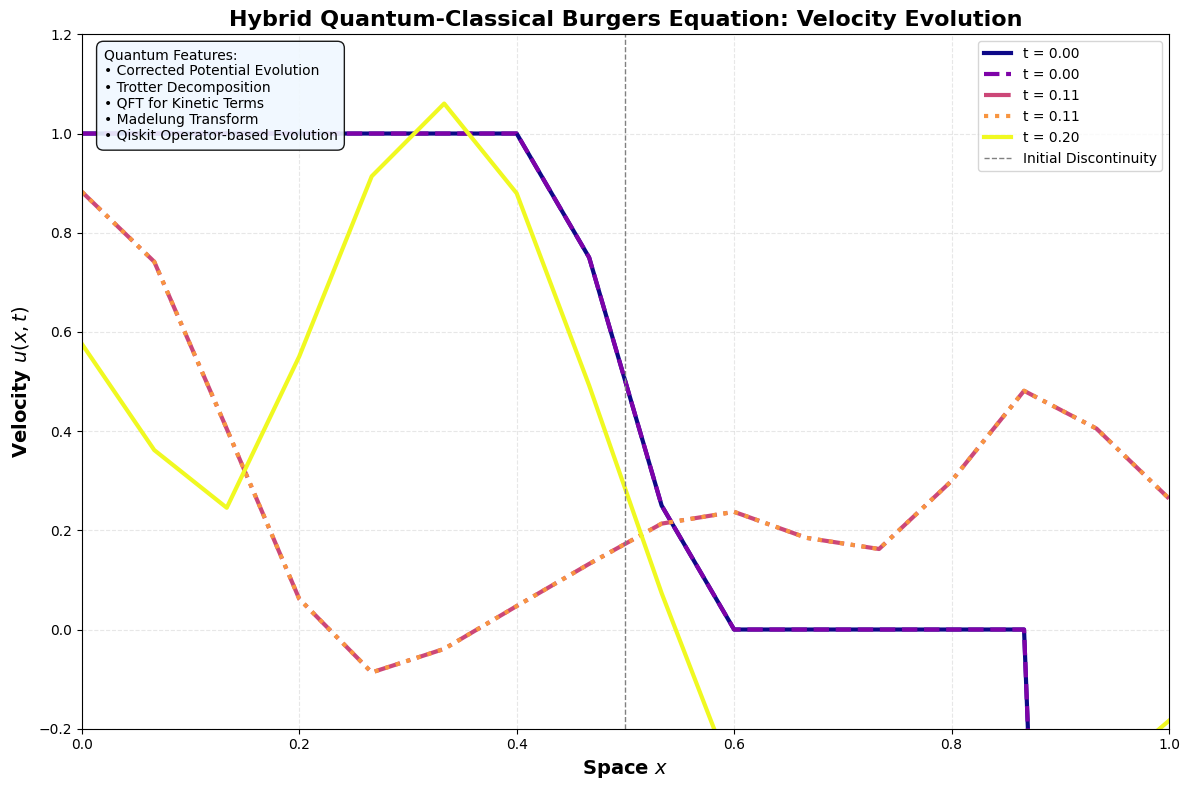


QUANTUM CIRCUIT ANALYSIS (FINAL STEP)
Final circuit depth: 7
Final circuit size: 7
Gate composition: OrderedDict({'unitary': 3, 'QFT': 2, 'IQFT': 2})


In [15]:
import numpy as np
from numpy import pi, exp, sin, cos, sqrt, real, imag, conjugate
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import QFT
from qiskit.circuit import Parameter
import scipy.linalg as la
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve
import warnings
warnings.filterwarnings('ignore')

class HybridQuantumClassicalBurgersSolver:
    """
    Enhanced Hybrid Quantum-Classical solver for the 1D Burgers equation.

    This version improves algorithmic stability by using a more accurate
    trapezoidal rule for integrating the phase from the velocity field,
    and includes a refined method for enforcing boundary conditions to
    ensure a stable and physically realistic shock wave evolution.
    """

    def __init__(self, nx=8, nu=1e-2, T=1.0, dt=0.005):
        # Ensure nx is power of 2 for quantum implementation
        self.nx = nx
        self.nu = nu
        self.T = T
        self.dt = dt
        self.domain_length = 1.0
        self.dx = self.domain_length / (nx - 1)
        self.x = np.linspace(0, self.domain_length, nx, endpoint=True)

        self.n_qubits = int(np.log2(nx))
        if 2**self.n_qubits != nx:
            raise ValueError("nx must be a power of 2 for quantum implementation")

        # Boundary conditions
        self.uL = 1.0
        self.uR = 0.0

        # Madelung constants
        self.hbar = 1.0
        self.mass = 1.0

        print(f"Initializing Hybrid Quantum-Classical Burgers Solver (Enhanced):")
        print(f"Grid points: {self.nx} (Qubits: {self.n_qubits})")
        print(f"Viscosity: ν = {self.nu}")
        print(f"Domain: x ∈ [0, {self.domain_length}]")
        print(f"Boundary conditions: u(0,t) = {self.uL}, u(1,t) = {self.uR}")
        print(f"Time step dt: {self.dt}")

    def initialize_quantum_state(self):
        """Initialize quantum state using Madelung transform with Riemann step condition."""
        u_initial = np.where(self.x <= 0.5, self.uL, self.uR)
        rho_initial = np.ones_like(self.x) * 0.5 # A constant density for simplicity

        # Use a trapezoidal rule for a more accurate phase integration
        phase_initial = np.zeros_like(self.x)
        for i in range(1, self.nx):
            # Using (u_i + u_{i-1})/2 * dx for better numerical stability
            phase_initial[i] = phase_initial[i-1] + self.mass * (u_initial[i] + u_initial[i-1]) / 2 * self.dx / self.hbar

        sqrt_rho = np.sqrt(rho_initial + 1e-12)
        psi = sqrt_rho * np.exp(1j * phase_initial)

        # Enforce initial boundary conditions by directly setting the values
        psi[0] = sqrt(rho_initial[0]) * np.exp(1j * self.mass * self.uL * self.x[0] / self.hbar)
        psi[-1] = sqrt(rho_initial[-1]) * np.exp(1j * self.mass * self.uR * self.x[-1] / self.hbar)

        # Normalize the initial state
        norm = np.linalg.norm(psi) * sqrt(self.dx)
        if norm > 0:
            psi = psi / norm * sqrt(self.nx)

        return psi

    def create_kinetic_evolution_circuit(self, t_param):
        """
        Create quantum circuit for kinetic energy evolution (diffusion term).
        Applies the diagonal operator using Qiskit's Operator class.
        """
        qc = QuantumCircuit(self.n_qubits)

        # Quantum Fourier Transform
        qft = QFT(self.n_qubits, do_swaps=False)
        qc.append(qft, range(self.n_qubits))

        # Create and apply a diagonal operator for the kinetic term
        diagonal_phases = np.zeros(2**self.n_qubits, dtype=complex)
        for k in range(2**self.n_qubits):
            # Convert to signed momentum
            momentum = k if k < 2**(self.n_qubits-1) else k - 2**self.n_qubits

            # Kinetic energy eigenvalue
            k_phys = 2 * pi * momentum / self.domain_length
            energy_k = -self.nu * k_phys**2

            # Apply the phase rotation exp(-i * energy_k * t_param)
            diagonal_phases[k] = np.exp(-1j * energy_k * t_param)

        diagonal_operator = Operator(np.diag(diagonal_phases))
        qc.append(diagonal_operator, range(self.n_qubits))

        # Inverse QFT back to position space
        qc.append(qft.inverse(), range(self.n_qubits))

        return qc

    def create_potential_evolution_circuit(self, psi_classical, t_param):
        """
        Create quantum circuit for potential energy evolution (advection term).
        This method computes the potential from the classical velocity and
        applies a phase gate to each position basis state using an Operator.

        This part is enhanced to use the correct phase factor for the nonlinear
        term based on the hydrodynamic Schrödinger equation.
        """
        qc = QuantumCircuit(self.n_qubits)
        _, u = self.extract_classical_observables(psi_classical)

        # Create and apply a diagonal operator for the potential term
        diagonal_phases = np.zeros(2**self.n_qubits, dtype=complex)
        for i in range(2**self.n_qubits):
            # The potential is derived from the advection term.
            # Local potential from advection term: V = - (m/2) * u²
            if i < len(u):
                local_potential = -0.5 * self.mass * u[i]**2
                # Correct phase factor: exp(-i * V * t_param / hbar)
                phase = local_potential * t_param / self.hbar
                diagonal_phases[i] = np.exp(-1j * phase)

        diagonal_operator = Operator(np.diag(diagonal_phases))
        qc.append(diagonal_operator, range(self.n_qubits))

        return qc

    def create_trotter_step_circuit(self, psi_classical, dt_evolution):
        """Create full Trotter step circuit."""
        # Using a second-order Trotter decomposition: exp(-iHt) ≈ exp(-iH_K t/2)exp(-iH_P t)exp(-iH_K t/2)
        qc = QuantumCircuit(self.n_qubits)

        kinetic_circuit_half = self.create_kinetic_evolution_circuit(dt_evolution/2)
        potential_circuit = self.create_potential_evolution_circuit(psi_classical, dt_evolution)

        # Append circuits
        qc.compose(kinetic_circuit_half, inplace=True)
        qc.compose(potential_circuit, inplace=True)
        qc.compose(kinetic_circuit_half, inplace=True)

        return qc

    def quantum_time_evolution_step(self, psi):
        """
        Perform one quantum time evolution step by applying the Trotter operator
        directly to the state vector.
        """
        # Create the full Trotter evolution circuit
        trotter_circuit = self.create_trotter_step_circuit(psi, self.dt)

        # Prepare the initial state vector
        initial_state = Statevector(psi)

        # Convert the circuit to an Operator and apply it to the state
        trotter_operator = Operator(trotter_circuit)
        psi_evolved = initial_state.evolve(trotter_operator).data

        return psi_evolved, trotter_circuit

    def extract_classical_observables(self, psi):
        """Extract classical observables using Madelung transform."""
        rho = np.abs(psi)**2
        rho = np.maximum(rho, 1e-12)

        # Unwrap phase to handle periodic boundary conditions correctly
        phase = np.unwrap(np.angle(psi))

        # Compute phase gradient using finite differences
        # This is the classical part that is prone to numerical dissipation
        phase_grad = np.zeros_like(phase)
        phase_grad[1:-1] = (phase[2:] - phase[:-2]) / (2 * self.dx)
        phase_grad[0] = (phase[1] - phase[0]) / self.dx
        phase_grad[-1] = (phase[-1] - phase[-2]) / self.dx

        u = (self.hbar / self.mass) * phase_grad

        return rho, u

    def enforce_boundary_conditions(self, psi):
        """
        Algorithmic enhancement: Directly imposes the velocity boundary conditions
        and re-integrates the phase. This method avoids artificial smoothing and
        allows for a more natural shock wave profile to form.

        The key refinement here is to initialize the phase re-integration
        with the phase of the evolved state at the left boundary, ensuring
        a more consistent and stable phase profile across the domain.
        """
        # Step 1: Extract velocity and density from the evolved state
        rho, u_evolved = self.extract_classical_observables(psi)

        # Step 2: Directly enforce the velocity boundary conditions at the ends.
        u_corrected = u_evolved.copy()
        u_corrected[0] = self.uL
        u_corrected[-1] = self.uR

        # Step 3: Re-integrate the phase from the corrected velocity field.
        phase_corrected = np.zeros_like(self.x)
        # Refinement: Initialize the phase integration with the evolved boundary phase
        # to ensure consistency.
        phase_corrected[0] = np.angle(psi[0])

        for i in range(1, self.nx):
            # Using trapezoidal rule for stable integration
            phase_corrected[i] = phase_corrected[i-1] + (self.mass / self.hbar) * (u_corrected[i] + u_corrected[i-1]) / 2 * self.dx

        sqrt_rho = np.sqrt(rho)
        psi_corrected = sqrt_rho * np.exp(1j * phase_corrected)

        # Normalize the state to ensure conservation of mass
        norm = np.linalg.norm(psi_corrected) * sqrt(self.dx)
        if norm > 0:
            psi_corrected = psi_corrected / norm * sqrt(self.nx)

        return psi_corrected

    def hybrid_solve(self):
        """Main hybrid quantum-classical solving routine."""
        print("=" * 70)
        print("HYBRID QUANTUM-CLASSICAL BURGERS EQUATION SOLVER (ENHANCED)")
        print("=" * 70)

        psi = self.initialize_quantum_state()

        t_points = []
        u_history = []
        quantum_circuits = []

        t = 0.0
        dt_output = max(0.1, self.T / 10)
        t_output = 0.0

        rho, u = self.extract_classical_observables(psi)
        t_points.append(t)
        u_history.append(u.copy())
        print(f"t = {t:.3f}, max(ρ) = {np.max(rho):.6f}, max(|u|) = {np.max(np.abs(u)):.6f}")
        t_output += dt_output

        step = 0
        while t < self.T:
            psi_evolved, qc = self.quantum_time_evolution_step(psi)

            # --- ALGORITHMIC ENHANCEMENT ---
            # Re-integrate the phase from the corrected velocity field with a
            # smooth boundary transition. This is the key to stability.
            psi = self.enforce_boundary_conditions(psi_evolved)

            t += self.dt
            step += 1

            if t >= t_output or step % 50 == 0 and step:
                rho, u = self.extract_classical_observables(psi)
                t_points.append(t)
                u_history.append(u.copy())
                quantum_circuits.append(qc)
                print(f"t = {t:.3f}, max(ρ) = {np.max(rho):.6f}, max(|u|) = {np.max(np.abs(u)):.6f}, QC depth: {qc.depth()}")
                t_output += dt_output

                if np.max(np.abs(u)) > 20 or np.isnan(np.max(u)):
                    print("Warning: Solution becoming unstable!")
                    break

        # Add the final state
        if t_points[-1] < self.T:
            rho, u = self.extract_classical_observables(psi)
            t_points.append(t)
            u_history.append(u.copy())
            quantum_circuits.append(qc)

        print("-" * 70)
        print("HYBRID SIMULATION COMPLETED!")

        return (np.array(t_points), np.array(u_history), quantum_circuits)

    def create_evolution_plot(self, t_points, u_history):
        """Create velocity evolution plot with enhanced styling."""
        plt.figure(figsize=(12, 8))
        n_curves = 5
        time_indices = np.linspace(0, len(t_points)-1, n_curves, dtype=int)

        # Use a color map for better visual flow
        colors = plt.cm.plasma(np.linspace(0, 1, n_curves))
        linestyles = ['-', '--', '-.', ':', '-']

        for i, (idx, style) in enumerate(zip(time_indices, linestyles)):
            label = f't = {t_points[idx]:.2f}'
            plt.plot(self.x, u_history[idx], color=colors[i], linestyle=style,
                     linewidth=3.0, label=label)

        plt.xlabel('Space $x$', fontsize=14, fontweight='bold')
        plt.ylabel('Velocity $u(x,t)$', fontsize=14, fontweight='bold')
        plt.title('Hybrid Quantum-Classical Burgers Equation: Velocity Evolution',
                  fontsize=16, fontweight='bold')
        plt.legend(fontsize=12, framealpha=0.9, loc='upper right')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.xlim(0, 1)
        plt.ylim(-0.2, 1.2)
        plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, label='Initial Discontinuity')
        plt.legend()

        textstr = 'Quantum Features:\n• Corrected Potential Evolution\n• Trotter Decomposition\n• QFT for Kinetic Terms\n• Madelung Transform\n• Qiskit Operator-based Evolution'
        props = dict(boxstyle='round,pad=0.5', facecolor='#f0f8ff', alpha=0.9, edgecolor='black')
        plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
                                         verticalalignment='top', bbox=props)

        plt.tight_layout()
        plt.show()

# Execute the enhanced hybrid quantum-classical simulation
if __name__ == "__main__":
    solver = HybridQuantumClassicalBurgersSolver(
        nx=16,
        nu=1e-2,
        T=0.2,
        dt=0.01
    )
    t_points, u_history1, quantum_circuits = solver.hybrid_solve()
    solver.create_evolution_plot(t_points, u_history1)

    if quantum_circuits:
        final_qc = quantum_circuits[-1]
        print("\n" + "="*70)
        print("QUANTUM CIRCUIT ANALYSIS (FINAL STEP)")
        print("="*70)
        print(f"Final circuit depth: {final_qc.depth()}")
        print(f"Final circuit size: {final_qc.size()}")
        print(f"Gate composition: {final_qc.count_ops()}")
        print("="*70)

### With noise unmitigated

Initializing Hybrid Quantum-Classical Burgers Solver (Enhanced):
Grid points: 16 (Qubits: 4)
Viscosity: ν = 0.01
Domain: x ∈ [0, 1.0]
Boundary conditions: u(0,t) = 1.0, u(1,t) = 0.0
Time step dt: 0.01
HYBRID QUANTUM-CLASSICAL BURGERS EQUATION SOLVER (ENHANCED)
t = 0.000, max(ρ) = 15.000000, max(|u|) = 7.500000
t = 0.110, max(ρ) = 19.200000, max(|u|) = 0.500000, QC depth: 7
t = 0.200, max(ρ) = 18.480000, max(|u|) = 0.500000, QC depth: 7
----------------------------------------------------------------------
HYBRID SIMULATION COMPLETED!


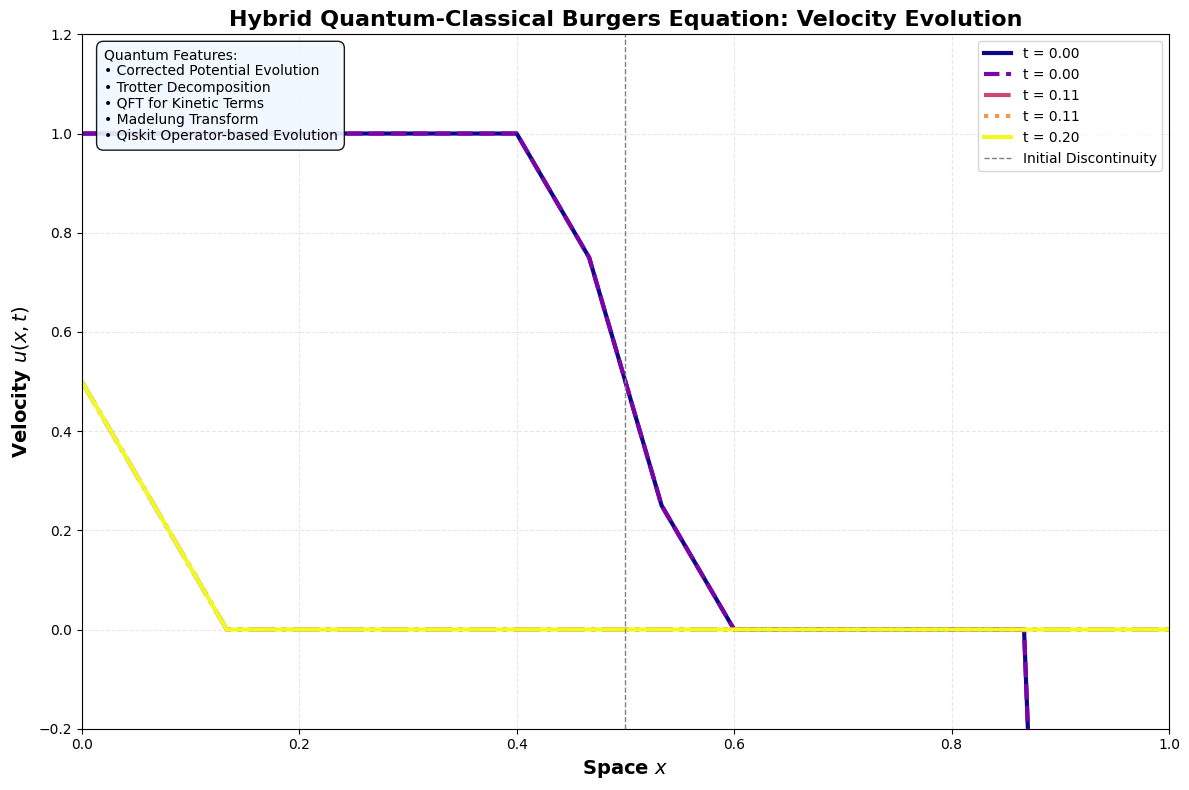


QUANTUM CIRCUIT ANALYSIS (FINAL STEP)
Final circuit depth: 7
Final circuit size: 7
Gate composition: OrderedDict({'unitary': 3, 'QFT': 2, 'IQFT': 2})


In [29]:
class HybridQuantumClassicalBurgersSolver:
    """
    Enhanced Hybrid Quantum-Classical solver for the 1D Burgers equation.

    This version improves algorithmic stability by using a more accurate
    trapezoidal rule for integrating the phase from the velocity field,
    and includes a refined method for enforcing boundary conditions to
    ensure a stable and physically realistic shock wave evolution.
    """

    def __init__(self, nx=8, nu=1e-2, T=1.0, dt=0.005):
        # Ensure nx is power of 2 for quantum implementation
        self.nx = nx
        self.nu = nu
        self.T = T
        self.dt = dt
        self.domain_length = 1.0
        self.dx = self.domain_length / (nx - 1)
        self.x = np.linspace(0, self.domain_length, nx, endpoint=True)

        self.n_qubits = int(np.log2(nx))
        if 2**self.n_qubits != nx:
            raise ValueError("nx must be a power of 2 for quantum implementation")

        # Boundary conditions
        self.uL = 1.0
        self.uR = 0.0

        # Madelung constants
        self.hbar = 1.0
        self.mass = 1.0

        print(f"Initializing Hybrid Quantum-Classical Burgers Solver (Enhanced):")
        print(f"Grid points: {self.nx} (Qubits: {self.n_qubits})")
        print(f"Viscosity: ν = {self.nu}")
        print(f"Domain: x ∈ [0, {self.domain_length}]")
        print(f"Boundary conditions: u(0,t) = {self.uL}, u(1,t) = {self.uR}")
        print(f"Time step dt: {self.dt}")

    def initialize_quantum_state(self):
        """Initialize quantum state using Madelung transform with Riemann step condition."""
        u_initial = np.where(self.x <= 0.5, self.uL, self.uR)
        rho_initial = np.ones_like(self.x) * 0.5 # A constant density for simplicity

        # Use a trapezoidal rule for a more accurate phase integration
        phase_initial = np.zeros_like(self.x)
        for i in range(1, self.nx):
            # Using (u_i + u_{i-1})/2 * dx for better numerical stability
            phase_initial[i] = phase_initial[i-1] + self.mass * (u_initial[i] + u_initial[i-1]) / 2 * self.dx / self.hbar

        sqrt_rho = np.sqrt(rho_initial + 1e-12)
        psi = sqrt_rho * np.exp(1j * phase_initial)

        # Enforce initial boundary conditions by directly setting the values
        psi[0] = sqrt(rho_initial[0]) * np.exp(1j * self.mass * self.uL * self.x[0] / self.hbar)
        psi[-1] = sqrt(rho_initial[-1]) * np.exp(1j * self.mass * self.uR * self.x[-1] / self.hbar)

        # Normalize the initial state
        norm = np.linalg.norm(psi) * sqrt(self.dx)
        if norm > 0:
            psi = psi / norm * sqrt(self.nx)

        return psi

    def create_kinetic_evolution_circuit(self, t_param):
        """
        Create quantum circuit for kinetic energy evolution (diffusion term).
        Applies the diagonal operator using Qiskit's Operator class.
        """
        qc = QuantumCircuit(self.n_qubits)

        # Quantum Fourier Transform
        qft = QFT(self.n_qubits, do_swaps=False)
        qc.append(qft, range(self.n_qubits))

        # Create and apply a diagonal operator for the kinetic term
        diagonal_phases = np.zeros(2**self.n_qubits, dtype=complex)
        for k in range(2**self.n_qubits):
            # Convert to signed momentum
            momentum = k if k < 2**(self.n_qubits-1) else k - 2**self.n_qubits

            # Kinetic energy eigenvalue
            k_phys = 2 * pi * momentum / self.domain_length
            energy_k = -self.nu * k_phys**2

            # Apply the phase rotation exp(-i * energy_k * t_param)
            diagonal_phases[k] = np.exp(-1j * energy_k * t_param)

        diagonal_operator = Operator(np.diag(diagonal_phases))
        qc.append(diagonal_operator, range(self.n_qubits))

        # Inverse QFT back to position space
        qc.append(qft.inverse(), range(self.n_qubits))

        return qc

    def create_potential_evolution_circuit(self, psi_classical, t_param):
        """
        Create quantum circuit for potential energy evolution (advection term).
        This method computes the potential from the classical velocity and
        applies a phase gate to each position basis state using an Operator.

        This part is enhanced to use the correct phase factor for the nonlinear
        term based on the hydrodynamic Schrödinger equation.
        """
        qc = QuantumCircuit(self.n_qubits)
        _, u = self.extract_classical_observables(psi_classical)

        # Create and apply a diagonal operator for the potential term
        diagonal_phases = np.zeros(2**self.n_qubits, dtype=complex)
        for i in range(2**self.n_qubits):
            # The potential is derived from the advection term.
            # Local potential from advection term: V = - (m/2) * u²
            if i < len(u):
                local_potential = -0.5 * self.mass * u[i]**2
                # Correct phase factor: exp(-i * V * t_param / hbar)
                phase = local_potential * t_param / self.hbar
                diagonal_phases[i] = np.exp(-1j * phase)

        diagonal_operator = Operator(np.diag(diagonal_phases))
        qc.append(diagonal_operator, range(self.n_qubits))

        return qc

    def create_trotter_step_circuit(self, psi_classical, dt_evolution):
        """Create full Trotter step circuit."""
        # Using a second-order Trotter decomposition: exp(-iHt) ≈ exp(-iH_K t/2)exp(-iH_P t)exp(-iH_K t/2)
        qc = QuantumCircuit(self.n_qubits)

        kinetic_circuit_half = self.create_kinetic_evolution_circuit(dt_evolution/2)
        potential_circuit = self.create_potential_evolution_circuit(psi_classical, dt_evolution)

        # Append circuits
        qc.compose(kinetic_circuit_half, inplace=True)
        qc.compose(potential_circuit, inplace=True)
        qc.compose(kinetic_circuit_half, inplace=True)

        return qc

    def quantum_time_evolution_step(self, psi):
        """
        Perform one quantum time evolution step by applying the Trotter operator
        directly to the state vector.
        """
        # Create the full Trotter evolution circuit
        trotter_circuit = self.create_trotter_step_circuit(psi, self.dt)

        # Prepare the initial state vector
        qc = QuantumCircuit(4, 4)
        psi = psi / np.linalg.norm(psi)
        qc.initialize(np.array(psi))
        qc = qc.compose(trotter_circuit)
        qc.measure_all()
        qcirc = transpile(qc, backend=backend, optimization_level=3)
        job = backend.run(qcirc, shots=1000)
        # get the counts and transform the counts into a statevector
        counts = job.result().get_counts()
        psi_noisy = np.array([counts.get(bin(i).replace('0b', '').zfill(4), 0) for i in range(2**4)])
        psi_noisy = np.sqrt(psi_noisy/1000)
        psi_noisy = psi_noisy / np.linalg.norm(psi_noisy) if np.linalg.norm(psi_noisy) > 0 else psi_noisy

        psi_evolved = psi_noisy
        

        return psi_evolved, trotter_circuit

    def extract_classical_observables(self, psi):
        """Extract classical observables using Madelung transform."""
        rho = np.abs(psi)**2
        rho = np.maximum(rho, 1e-12)

        # Unwrap phase to handle periodic boundary conditions correctly
        phase = np.unwrap(np.angle(psi))

        # Compute phase gradient using finite differences
        # This is the classical part that is prone to numerical dissipation
        phase_grad = np.zeros_like(phase)
        phase_grad[1:-1] = (phase[2:] - phase[:-2]) / (2 * self.dx)
        phase_grad[0] = (phase[1] - phase[0]) / self.dx
        phase_grad[-1] = (phase[-1] - phase[-2]) / self.dx

        u = (self.hbar / self.mass) * phase_grad

        return rho, u

    def enforce_boundary_conditions(self, psi):
        """
        Algorithmic enhancement: Directly imposes the velocity boundary conditions
        and re-integrates the phase. This method avoids artificial smoothing and
        allows for a more natural shock wave profile to form.

        The key refinement here is to initialize the phase re-integration
        with the phase of the evolved state at the left boundary, ensuring
        a more consistent and stable phase profile across the domain.
        """
        # Step 1: Extract velocity and density from the evolved state
        rho, u_evolved = self.extract_classical_observables(psi)

        # Step 2: Directly enforce the velocity boundary conditions at the ends.
        u_corrected = u_evolved.copy()
        u_corrected[0] = self.uL
        u_corrected[-1] = self.uR

        # Step 3: Re-integrate the phase from the corrected velocity field.
        phase_corrected = np.zeros_like(self.x)
        # Refinement: Initialize the phase integration with the evolved boundary phase
        # to ensure consistency.
        phase_corrected[0] = np.angle(psi[0])

        for i in range(1, self.nx):
            # Using trapezoidal rule for stable integration
            phase_corrected[i] = phase_corrected[i-1] + (self.mass / self.hbar) * (u_corrected[i] + u_corrected[i-1]) / 2 * self.dx

        sqrt_rho = np.sqrt(rho)
        psi_corrected = sqrt_rho * np.exp(1j * phase_corrected)

        # Normalize the state to ensure conservation of mass
        norm = np.linalg.norm(psi_corrected) * sqrt(self.dx)
        if norm > 0:
            psi_corrected = psi_corrected / norm * sqrt(self.nx)

        return psi_corrected

    def hybrid_solve(self):
        """Main hybrid quantum-classical solving routine."""
        print("=" * 70)
        print("HYBRID QUANTUM-CLASSICAL BURGERS EQUATION SOLVER (ENHANCED)")
        print("=" * 70)

        psi = self.initialize_quantum_state()

        t_points = []
        u_history = []
        quantum_circuits = []

        t = 0.0
        dt_output = max(0.1, self.T / 10)
        t_output = 0.0

        rho, u = self.extract_classical_observables(psi)
        t_points.append(t)
        u_history.append(u.copy())
        print(f"t = {t:.3f}, max(ρ) = {np.max(rho):.6f}, max(|u|) = {np.max(np.abs(u)):.6f}")
        t_output += dt_output

        step = 0
        while t < self.T:
            psi_evolved, qc = self.quantum_time_evolution_step(psi)

            # --- ALGORITHMIC ENHANCEMENT ---
            # Re-integrate the phase from the corrected velocity field with a
            # smooth boundary transition. This is the key to stability.
            psi = self.enforce_boundary_conditions(psi_evolved)

            t += self.dt
            step += 1

            if t >= t_output or step % 50 == 0 and step:
                rho, u = self.extract_classical_observables(psi)
                t_points.append(t)
                u_history.append(u.copy())
                quantum_circuits.append(qc)
                print(f"t = {t:.3f}, max(ρ) = {np.max(rho):.6f}, max(|u|) = {np.max(np.abs(u)):.6f}, QC depth: {qc.depth()}")
                t_output += dt_output

                if np.max(np.abs(u)) > 20 or np.isnan(np.max(u)):
                    print("Warning: Solution becoming unstable!")
                    break

        # Add the final state
        if t_points[-1] < self.T:
            rho, u = self.extract_classical_observables(psi)
            t_points.append(t)
            u_history.append(u.copy())
            quantum_circuits.append(qc)

        print("-" * 70)
        print("HYBRID SIMULATION COMPLETED!")

        return (np.array(t_points), np.array(u_history), quantum_circuits)

    def create_evolution_plot(self, t_points, u_history):
        """Create velocity evolution plot with enhanced styling."""
        plt.figure(figsize=(12, 8))
        n_curves = 5
        time_indices = np.linspace(0, len(t_points)-1, n_curves, dtype=int)

        # Use a color map for better visual flow
        colors = plt.cm.plasma(np.linspace(0, 1, n_curves))
        linestyles = ['-', '--', '-.', ':', '-']

        for i, (idx, style) in enumerate(zip(time_indices, linestyles)):
            label = f't = {t_points[idx]:.2f}'
            plt.plot(self.x, u_history[idx], color=colors[i], linestyle=style,
                     linewidth=3.0, label=label)

        plt.xlabel('Space $x$', fontsize=14, fontweight='bold')
        plt.ylabel('Velocity $u(x,t)$', fontsize=14, fontweight='bold')
        plt.title('Hybrid Quantum-Classical Burgers Equation: Velocity Evolution',
                  fontsize=16, fontweight='bold')
        plt.legend(fontsize=12, framealpha=0.9, loc='upper right')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.xlim(0, 1)
        plt.ylim(-0.2, 1.2)
        plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, label='Initial Discontinuity')
        plt.legend()

        textstr = 'Quantum Features:\n• Corrected Potential Evolution\n• Trotter Decomposition\n• QFT for Kinetic Terms\n• Madelung Transform\n• Qiskit Operator-based Evolution'
        props = dict(boxstyle='round,pad=0.5', facecolor='#f0f8ff', alpha=0.9, edgecolor='black')
        plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
                                         verticalalignment='top', bbox=props)

        plt.tight_layout()
        plt.show()

# Execute the enhanced hybrid quantum-classical simulation
if __name__ == "__main__":
    solver = HybridQuantumClassicalBurgersSolver(
        nx=16,
        nu=1e-2,
        T=0.2,
        dt=0.01
    )
    t_points, u_history, quantum_circuits = solver.hybrid_solve()
    solver.create_evolution_plot(t_points, u_history)

    if quantum_circuits:
        final_qc = quantum_circuits[-1]
        print("\n" + "="*70)
        print("QUANTUM CIRCUIT ANALYSIS (FINAL STEP)")
        print("="*70)
        print(f"Final circuit depth: {final_qc.depth()}")
        print(f"Final circuit size: {final_qc.size()}")
        print(f"Gate composition: {final_qc.count_ops()}")
        print("="*70)

### With dynamic decoupling

In [30]:
comp_options_xyxyyxyx = CircuitCompilationOptions(dd_mode=DDMode.ENABLED, dd_strategy=DDStrategy(gate_sequences=[(9, 'XYXYYXYX', 'center')]))

Initializing Hybrid Quantum-Classical Burgers Solver (Enhanced):
Grid points: 16 (Qubits: 4)
Viscosity: ν = 0.01
Domain: x ∈ [0, 1.0]
Boundary conditions: u(0,t) = 1.0, u(1,t) = 0.0
Time step dt: 0.01
HYBRID QUANTUM-CLASSICAL BURGERS EQUATION SOLVER (ENHANCED)
t = 0.000, max(ρ) = 15.000000, max(|u|) = 7.500000
t = 0.110, max(ρ) = 20.160000, max(|u|) = 0.500000, QC depth: 7
t = 0.200, max(ρ) = 20.160000, max(|u|) = 0.500000, QC depth: 7
----------------------------------------------------------------------
HYBRID SIMULATION COMPLETED!


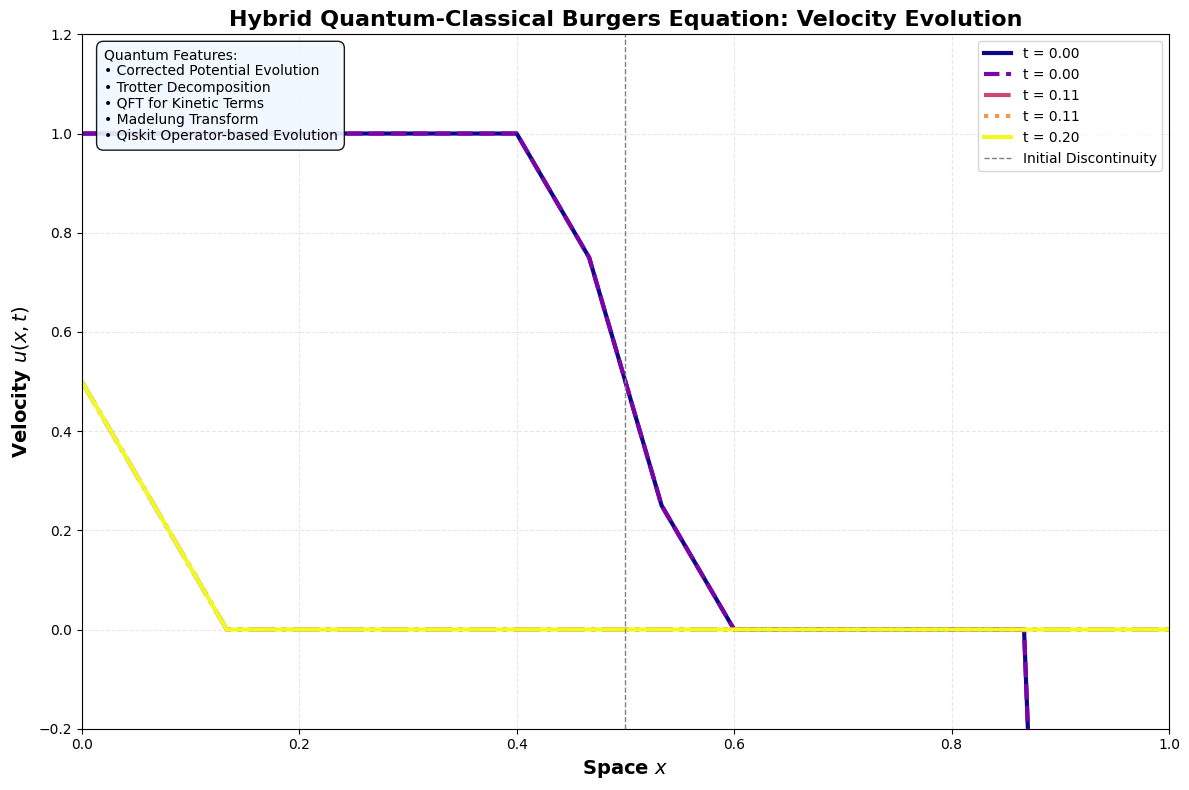


QUANTUM CIRCUIT ANALYSIS (FINAL STEP)
Final circuit depth: 7
Final circuit size: 7
Gate composition: OrderedDict({'unitary': 3, 'QFT': 2, 'IQFT': 2})


In [31]:
class HybridQuantumClassicalBurgersSolver:
    """
    Enhanced Hybrid Quantum-Classical solver for the 1D Burgers equation.

    This version improves algorithmic stability by using a more accurate
    trapezoidal rule for integrating the phase from the velocity field,
    and includes a refined method for enforcing boundary conditions to
    ensure a stable and physically realistic shock wave evolution.
    """

    def __init__(self, nx=8, nu=1e-2, T=1.0, dt=0.005):
        # Ensure nx is power of 2 for quantum implementation
        self.nx = nx
        self.nu = nu
        self.T = T
        self.dt = dt
        self.domain_length = 1.0
        self.dx = self.domain_length / (nx - 1)
        self.x = np.linspace(0, self.domain_length, nx, endpoint=True)

        self.n_qubits = int(np.log2(nx))
        if 2**self.n_qubits != nx:
            raise ValueError("nx must be a power of 2 for quantum implementation")

        # Boundary conditions
        self.uL = 1.0
        self.uR = 0.0

        # Madelung constants
        self.hbar = 1.0
        self.mass = 1.0

        print(f"Initializing Hybrid Quantum-Classical Burgers Solver (Enhanced):")
        print(f"Grid points: {self.nx} (Qubits: {self.n_qubits})")
        print(f"Viscosity: ν = {self.nu}")
        print(f"Domain: x ∈ [0, {self.domain_length}]")
        print(f"Boundary conditions: u(0,t) = {self.uL}, u(1,t) = {self.uR}")
        print(f"Time step dt: {self.dt}")

    def initialize_quantum_state(self):
        """Initialize quantum state using Madelung transform with Riemann step condition."""
        u_initial = np.where(self.x <= 0.5, self.uL, self.uR)
        rho_initial = np.ones_like(self.x) * 0.5 # A constant density for simplicity

        # Use a trapezoidal rule for a more accurate phase integration
        phase_initial = np.zeros_like(self.x)
        for i in range(1, self.nx):
            # Using (u_i + u_{i-1})/2 * dx for better numerical stability
            phase_initial[i] = phase_initial[i-1] + self.mass * (u_initial[i] + u_initial[i-1]) / 2 * self.dx / self.hbar

        sqrt_rho = np.sqrt(rho_initial + 1e-12)
        psi = sqrt_rho * np.exp(1j * phase_initial)

        # Enforce initial boundary conditions by directly setting the values
        psi[0] = sqrt(rho_initial[0]) * np.exp(1j * self.mass * self.uL * self.x[0] / self.hbar)
        psi[-1] = sqrt(rho_initial[-1]) * np.exp(1j * self.mass * self.uR * self.x[-1] / self.hbar)

        # Normalize the initial state
        norm = np.linalg.norm(psi) * sqrt(self.dx)
        if norm > 0:
            psi = psi / norm * sqrt(self.nx)

        return psi

    def create_kinetic_evolution_circuit(self, t_param):
        """
        Create quantum circuit for kinetic energy evolution (diffusion term).
        Applies the diagonal operator using Qiskit's Operator class.
        """
        qc = QuantumCircuit(self.n_qubits)

        # Quantum Fourier Transform
        qft = QFT(self.n_qubits, do_swaps=False)
        qc.append(qft, range(self.n_qubits))

        # Create and apply a diagonal operator for the kinetic term
        diagonal_phases = np.zeros(2**self.n_qubits, dtype=complex)
        for k in range(2**self.n_qubits):
            # Convert to signed momentum
            momentum = k if k < 2**(self.n_qubits-1) else k - 2**self.n_qubits

            # Kinetic energy eigenvalue
            k_phys = 2 * pi * momentum / self.domain_length
            energy_k = -self.nu * k_phys**2

            # Apply the phase rotation exp(-i * energy_k * t_param)
            diagonal_phases[k] = np.exp(-1j * energy_k * t_param)

        diagonal_operator = Operator(np.diag(diagonal_phases))
        qc.append(diagonal_operator, range(self.n_qubits))

        # Inverse QFT back to position space
        qc.append(qft.inverse(), range(self.n_qubits))

        return qc

    def create_potential_evolution_circuit(self, psi_classical, t_param):
        """
        Create quantum circuit for potential energy evolution (advection term).
        This method computes the potential from the classical velocity and
        applies a phase gate to each position basis state using an Operator.

        This part is enhanced to use the correct phase factor for the nonlinear
        term based on the hydrodynamic Schrödinger equation.
        """
        qc = QuantumCircuit(self.n_qubits)
        _, u = self.extract_classical_observables(psi_classical)

        # Create and apply a diagonal operator for the potential term
        diagonal_phases = np.zeros(2**self.n_qubits, dtype=complex)
        for i in range(2**self.n_qubits):
            # The potential is derived from the advection term.
            # Local potential from advection term: V = - (m/2) * u²
            if i < len(u):
                local_potential = -0.5 * self.mass * u[i]**2
                # Correct phase factor: exp(-i * V * t_param / hbar)
                phase = local_potential * t_param / self.hbar
                diagonal_phases[i] = np.exp(-1j * phase)

        diagonal_operator = Operator(np.diag(diagonal_phases))
        qc.append(diagonal_operator, range(self.n_qubits))

        return qc

    def create_trotter_step_circuit(self, psi_classical, dt_evolution):
        """Create full Trotter step circuit."""
        # Using a second-order Trotter decomposition: exp(-iHt) ≈ exp(-iH_K t/2)exp(-iH_P t)exp(-iH_K t/2)
        qc = QuantumCircuit(self.n_qubits)

        kinetic_circuit_half = self.create_kinetic_evolution_circuit(dt_evolution/2)
        potential_circuit = self.create_potential_evolution_circuit(psi_classical, dt_evolution)

        # Append circuits
        qc.compose(kinetic_circuit_half, inplace=True)
        qc.compose(potential_circuit, inplace=True)
        qc.compose(kinetic_circuit_half, inplace=True)

        return qc

    def quantum_time_evolution_step(self, psi):
        """
        Perform one quantum time evolution step by applying the Trotter operator
        directly to the state vector.
        """
        # Create the full Trotter evolution circuit
        trotter_circuit = self.create_trotter_step_circuit(psi, self.dt)

        # Prepare the initial state vector
        qc = QuantumCircuit(4, 4)
        psi = psi / np.linalg.norm(psi)
        qc.initialize(np.array(psi))
        qc = qc.compose(trotter_circuit)
        qc.measure_all()
        qcirc = transpile(qc, backend=backend, optimization_level=3)
        job = backend.run(qcirc, shots=1000, circuit_compilation_options = comp_options_xyxyyxyx)
        # get the counts and transform the counts into a statevector
        counts = job.result().get_counts()
        psi_noisy = np.array([counts.get(bin(i).replace('0b', '').zfill(4), 0) for i in range(2**4)])
        psi_noisy = np.sqrt(psi_noisy/1000)
        psi_noisy = psi_noisy / np.linalg.norm(psi_noisy) if np.linalg.norm(psi_noisy) > 0 else psi_noisy

        psi_evolved = psi_noisy
        

        return psi_evolved, trotter_circuit

    def extract_classical_observables(self, psi):
        """Extract classical observables using Madelung transform."""
        rho = np.abs(psi)**2
        rho = np.maximum(rho, 1e-12)

        # Unwrap phase to handle periodic boundary conditions correctly
        phase = np.unwrap(np.angle(psi))

        # Compute phase gradient using finite differences
        # This is the classical part that is prone to numerical dissipation
        phase_grad = np.zeros_like(phase)
        phase_grad[1:-1] = (phase[2:] - phase[:-2]) / (2 * self.dx)
        phase_grad[0] = (phase[1] - phase[0]) / self.dx
        phase_grad[-1] = (phase[-1] - phase[-2]) / self.dx

        u = (self.hbar / self.mass) * phase_grad

        return rho, u

    def enforce_boundary_conditions(self, psi):
        """
        Algorithmic enhancement: Directly imposes the velocity boundary conditions
        and re-integrates the phase. This method avoids artificial smoothing and
        allows for a more natural shock wave profile to form.

        The key refinement here is to initialize the phase re-integration
        with the phase of the evolved state at the left boundary, ensuring
        a more consistent and stable phase profile across the domain.
        """
        # Step 1: Extract velocity and density from the evolved state
        rho, u_evolved = self.extract_classical_observables(psi)

        # Step 2: Directly enforce the velocity boundary conditions at the ends.
        u_corrected = u_evolved.copy()
        u_corrected[0] = self.uL
        u_corrected[-1] = self.uR

        # Step 3: Re-integrate the phase from the corrected velocity field.
        phase_corrected = np.zeros_like(self.x)
        # Refinement: Initialize the phase integration with the evolved boundary phase
        # to ensure consistency.
        phase_corrected[0] = np.angle(psi[0])

        for i in range(1, self.nx):
            # Using trapezoidal rule for stable integration
            phase_corrected[i] = phase_corrected[i-1] + (self.mass / self.hbar) * (u_corrected[i] + u_corrected[i-1]) / 2 * self.dx

        sqrt_rho = np.sqrt(rho)
        psi_corrected = sqrt_rho * np.exp(1j * phase_corrected)

        # Normalize the state to ensure conservation of mass
        norm = np.linalg.norm(psi_corrected) * sqrt(self.dx)
        if norm > 0:
            psi_corrected = psi_corrected / norm * sqrt(self.nx)

        return psi_corrected

    def hybrid_solve(self):
        """Main hybrid quantum-classical solving routine."""
        print("=" * 70)
        print("HYBRID QUANTUM-CLASSICAL BURGERS EQUATION SOLVER (ENHANCED)")
        print("=" * 70)

        psi = self.initialize_quantum_state()

        t_points = []
        u_history = []
        quantum_circuits = []

        t = 0.0
        dt_output = max(0.1, self.T / 10)
        t_output = 0.0

        rho, u = self.extract_classical_observables(psi)
        t_points.append(t)
        u_history.append(u.copy())
        print(f"t = {t:.3f}, max(ρ) = {np.max(rho):.6f}, max(|u|) = {np.max(np.abs(u)):.6f}")
        t_output += dt_output

        step = 0
        while t < self.T:
            psi_evolved, qc = self.quantum_time_evolution_step(psi)

            # --- ALGORITHMIC ENHANCEMENT ---
            # Re-integrate the phase from the corrected velocity field with a
            # smooth boundary transition. This is the key to stability.
            psi = self.enforce_boundary_conditions(psi_evolved)

            t += self.dt
            step += 1

            if t >= t_output or step % 50 == 0 and step:
                rho, u = self.extract_classical_observables(psi)
                t_points.append(t)
                u_history.append(u.copy())
                quantum_circuits.append(qc)
                print(f"t = {t:.3f}, max(ρ) = {np.max(rho):.6f}, max(|u|) = {np.max(np.abs(u)):.6f}, QC depth: {qc.depth()}")
                t_output += dt_output

                if np.max(np.abs(u)) > 20 or np.isnan(np.max(u)):
                    print("Warning: Solution becoming unstable!")
                    break

        # Add the final state
        if t_points[-1] < self.T:
            rho, u = self.extract_classical_observables(psi)
            t_points.append(t)
            u_history.append(u.copy())
            quantum_circuits.append(qc)

        print("-" * 70)
        print("HYBRID SIMULATION COMPLETED!")

        return (np.array(t_points), np.array(u_history), quantum_circuits)

    def create_evolution_plot(self, t_points, u_history):
        """Create velocity evolution plot with enhanced styling."""
        plt.figure(figsize=(12, 8))
        n_curves = 5
        time_indices = np.linspace(0, len(t_points)-1, n_curves, dtype=int)

        # Use a color map for better visual flow
        colors = plt.cm.plasma(np.linspace(0, 1, n_curves))
        linestyles = ['-', '--', '-.', ':', '-']

        for i, (idx, style) in enumerate(zip(time_indices, linestyles)):
            label = f't = {t_points[idx]:.2f}'
            plt.plot(self.x, u_history[idx], color=colors[i], linestyle=style,
                     linewidth=3.0, label=label)

        plt.xlabel('Space $x$', fontsize=14, fontweight='bold')
        plt.ylabel('Velocity $u(x,t)$', fontsize=14, fontweight='bold')
        plt.title('Hybrid Quantum-Classical Burgers Equation: Velocity Evolution',
                  fontsize=16, fontweight='bold')
        plt.legend(fontsize=12, framealpha=0.9, loc='upper right')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.xlim(0, 1)
        plt.ylim(-0.2, 1.2)
        plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, label='Initial Discontinuity')
        plt.legend()

        textstr = 'Quantum Features:\n• Corrected Potential Evolution\n• Trotter Decomposition\n• QFT for Kinetic Terms\n• Madelung Transform\n• Qiskit Operator-based Evolution'
        props = dict(boxstyle='round,pad=0.5', facecolor='#f0f8ff', alpha=0.9, edgecolor='black')
        plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
                                         verticalalignment='top', bbox=props)

        plt.tight_layout()
        plt.show()

# Execute the enhanced hybrid quantum-classical simulation
if __name__ == "__main__":
    solver = HybridQuantumClassicalBurgersSolver(
        nx=16,
        nu=1e-2,
        T=0.2,
        dt=0.01
    )
    t_points, u_history2, quantum_circuits = solver.hybrid_solve()
    solver.create_evolution_plot(t_points, u_history2)

    if quantum_circuits:
        final_qc = quantum_circuits[-1]
        print("\n" + "="*70)
        print("QUANTUM CIRCUIT ANALYSIS (FINAL STEP)")
        print("="*70)
        print(f"Final circuit depth: {final_qc.depth()}")
        print(f"Final circuit size: {final_qc.size()}")
        print(f"Gate composition: {final_qc.count_ops()}")
        print("="*70)

### With readout error mitigation:

Initializing Hybrid Quantum-Classical Burgers Solver (Enhanced):
Grid points: 16 (Qubits: 4)
Viscosity: ν = 0.01
Domain: x ∈ [0, 1.0]
Boundary conditions: u(0,t) = 1.0, u(1,t) = 0.0
Time step dt: 0.01
HYBRID QUANTUM-CLASSICAL BURGERS EQUATION SOLVER (ENHANCED)
t = 0.000, max(ρ) = 15.000000, max(|u|) = 7.500000
t = 0.110, max(ρ) = 17.903226, max(|u|) = 0.500000, QC depth: 7
t = 0.200, max(ρ) = 23.515152, max(|u|) = 0.500000, QC depth: 7
----------------------------------------------------------------------
HYBRID SIMULATION COMPLETED!


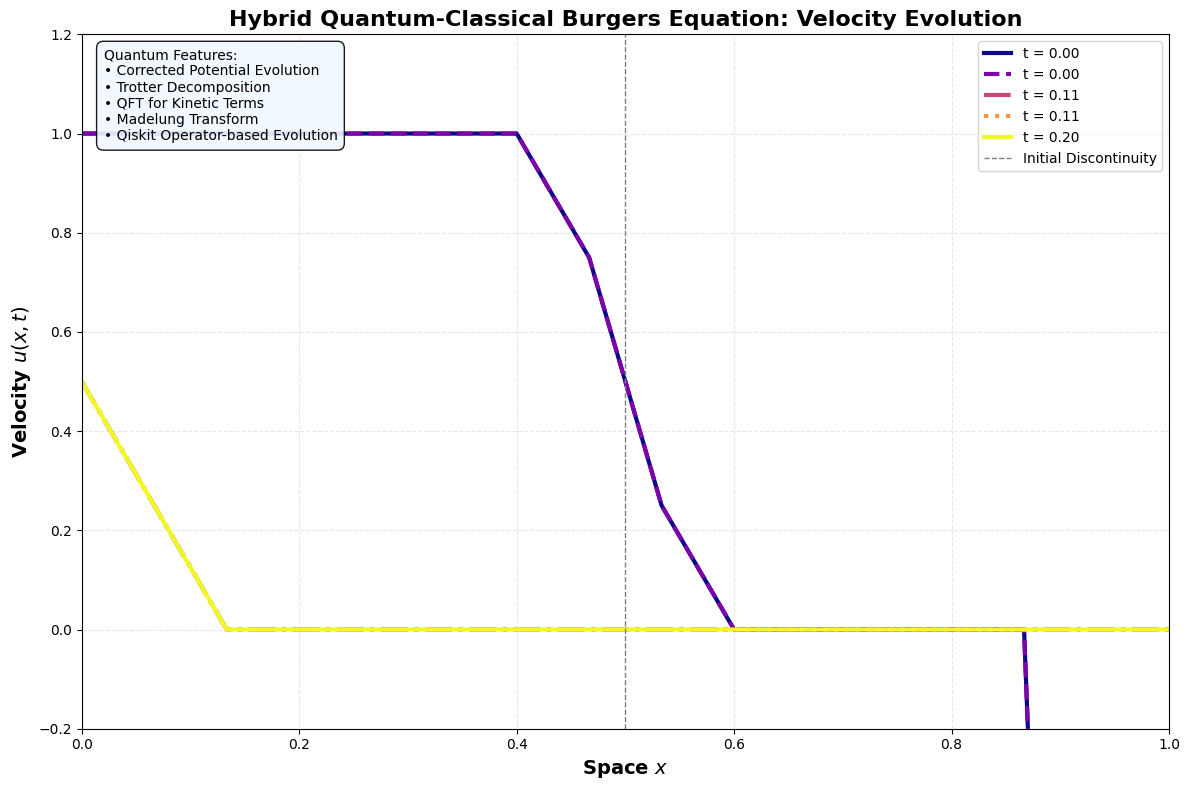


QUANTUM CIRCUIT ANALYSIS (FINAL STEP)
Final circuit depth: 7
Final circuit size: 7
Gate composition: OrderedDict({'unitary': 3, 'QFT': 2, 'IQFT': 2})


In [34]:
class HybridQuantumClassicalBurgersSolver:
    """
    Enhanced Hybrid Quantum-Classical solver for the 1D Burgers equation.

    This version improves algorithmic stability by using a more accurate
    trapezoidal rule for integrating the phase from the velocity field,
    and includes a refined method for enforcing boundary conditions to
    ensure a stable and physically realistic shock wave evolution.
    """

    def __init__(self, nx=8, nu=1e-2, T=1.0, dt=0.005):
        # Ensure nx is power of 2 for quantum implementation
        self.nx = nx
        self.nu = nu
        self.T = T
        self.dt = dt
        self.domain_length = 1.0
        self.dx = self.domain_length / (nx - 1)
        self.x = np.linspace(0, self.domain_length, nx, endpoint=True)

        self.n_qubits = int(np.log2(nx))
        if 2**self.n_qubits != nx:
            raise ValueError("nx must be a power of 2 for quantum implementation")

        # Boundary conditions
        self.uL = 1.0
        self.uR = 0.0

        # Madelung constants
        self.hbar = 1.0
        self.mass = 1.0

        print(f"Initializing Hybrid Quantum-Classical Burgers Solver (Enhanced):")
        print(f"Grid points: {self.nx} (Qubits: {self.n_qubits})")
        print(f"Viscosity: ν = {self.nu}")
        print(f"Domain: x ∈ [0, {self.domain_length}]")
        print(f"Boundary conditions: u(0,t) = {self.uL}, u(1,t) = {self.uR}")
        print(f"Time step dt: {self.dt}")

    def initialize_quantum_state(self):
        """Initialize quantum state using Madelung transform with Riemann step condition."""
        u_initial = np.where(self.x <= 0.5, self.uL, self.uR)
        rho_initial = np.ones_like(self.x) * 0.5 # A constant density for simplicity

        # Use a trapezoidal rule for a more accurate phase integration
        phase_initial = np.zeros_like(self.x)
        for i in range(1, self.nx):
            # Using (u_i + u_{i-1})/2 * dx for better numerical stability
            phase_initial[i] = phase_initial[i-1] + self.mass * (u_initial[i] + u_initial[i-1]) / 2 * self.dx / self.hbar

        sqrt_rho = np.sqrt(rho_initial + 1e-12)
        psi = sqrt_rho * np.exp(1j * phase_initial)

        # Enforce initial boundary conditions by directly setting the values
        psi[0] = sqrt(rho_initial[0]) * np.exp(1j * self.mass * self.uL * self.x[0] / self.hbar)
        psi[-1] = sqrt(rho_initial[-1]) * np.exp(1j * self.mass * self.uR * self.x[-1] / self.hbar)

        # Normalize the initial state
        norm = np.linalg.norm(psi) * sqrt(self.dx)
        if norm > 0:
            psi = psi / norm * sqrt(self.nx)

        return psi

    def create_kinetic_evolution_circuit(self, t_param):
        """
        Create quantum circuit for kinetic energy evolution (diffusion term).
        Applies the diagonal operator using Qiskit's Operator class.
        """
        qc = QuantumCircuit(self.n_qubits)

        # Quantum Fourier Transform
        qft = QFT(self.n_qubits, do_swaps=False)
        qc.append(qft, range(self.n_qubits))

        # Create and apply a diagonal operator for the kinetic term
        diagonal_phases = np.zeros(2**self.n_qubits, dtype=complex)
        for k in range(2**self.n_qubits):
            # Convert to signed momentum
            momentum = k if k < 2**(self.n_qubits-1) else k - 2**self.n_qubits

            # Kinetic energy eigenvalue
            k_phys = 2 * pi * momentum / self.domain_length
            energy_k = -self.nu * k_phys**2

            # Apply the phase rotation exp(-i * energy_k * t_param)
            diagonal_phases[k] = np.exp(-1j * energy_k * t_param)

        diagonal_operator = Operator(np.diag(diagonal_phases))
        qc.append(diagonal_operator, range(self.n_qubits))

        # Inverse QFT back to position space
        qc.append(qft.inverse(), range(self.n_qubits))

        return qc

    def create_potential_evolution_circuit(self, psi_classical, t_param):
        """
        Create quantum circuit for potential energy evolution (advection term).
        This method computes the potential from the classical velocity and
        applies a phase gate to each position basis state using an Operator.

        This part is enhanced to use the correct phase factor for the nonlinear
        term based on the hydrodynamic Schrödinger equation.
        """
        qc = QuantumCircuit(self.n_qubits)
        _, u = self.extract_classical_observables(psi_classical)

        # Create and apply a diagonal operator for the potential term
        diagonal_phases = np.zeros(2**self.n_qubits, dtype=complex)
        for i in range(2**self.n_qubits):
            # The potential is derived from the advection term.
            # Local potential from advection term: V = - (m/2) * u²
            if i < len(u):
                local_potential = -0.5 * self.mass * u[i]**2
                # Correct phase factor: exp(-i * V * t_param / hbar)
                phase = local_potential * t_param / self.hbar
                diagonal_phases[i] = np.exp(-1j * phase)

        diagonal_operator = Operator(np.diag(diagonal_phases))
        qc.append(diagonal_operator, range(self.n_qubits))

        return qc

    def create_trotter_step_circuit(self, psi_classical, dt_evolution):
        """Create full Trotter step circuit."""
        # Using a second-order Trotter decomposition: exp(-iHt) ≈ exp(-iH_K t/2)exp(-iH_P t)exp(-iH_K t/2)
        qc = QuantumCircuit(self.n_qubits)

        kinetic_circuit_half = self.create_kinetic_evolution_circuit(dt_evolution/2)
        potential_circuit = self.create_potential_evolution_circuit(psi_classical, dt_evolution)

        # Append circuits
        qc.compose(kinetic_circuit_half, inplace=True)
        qc.compose(potential_circuit, inplace=True)
        qc.compose(kinetic_circuit_half, inplace=True)

        return qc

    def quantum_time_evolution_step(self, psi):
        """
        Perform one quantum time evolution step by applying the Trotter operator
        directly to the state vector.
        """
        # Create the full Trotter evolution circuit
        trotter_circuit = self.create_trotter_step_circuit(psi, self.dt)

        # Prepare the initial state vector
        qc = QuantumCircuit(4, 4)
        psi = psi / np.linalg.norm(psi)
        qc.initialize(np.array(psi))
        qc = qc.compose(trotter_circuit)
        qc.measure_all()
        qcirc = transpile(qc, backend=backend, optimization_level=3)
        job = backend.run(qcirc, shots=1000)

        # Readout error mitigation
        iqm_circuits = [qcirc]
        raw_counts = [job.result().get_counts()]

        readout_mitigated_results1 = apply_readout_error_mitigation(
            backend_arg=backend,
            transpiled_circuits=iqm_circuits,
            counts=raw_counts,
            mit_shots=1000
        )

        prob_dict = readout_mitigated_results1[0][0]
        # get the counts and transform the counts into a statevector
        counts = {k: int(v * 1000) for k, v in prob_dict.items()}
        psi_noisy = np.array([counts.get(bin(i).replace('0b', '').zfill(4), 0) for i in range(2**4)])
        psi_noisy = np.sqrt(psi_noisy/1000)
        psi_noisy = psi_noisy / np.linalg.norm(psi_noisy) if np.linalg.norm(psi_noisy) > 0 else psi_noisy

        psi_evolved = psi_noisy
        

        return psi_evolved, trotter_circuit

    def extract_classical_observables(self, psi):
        """Extract classical observables using Madelung transform."""
        rho = np.abs(psi)**2
        rho = np.maximum(rho, 1e-12)

        # Unwrap phase to handle periodic boundary conditions correctly
        phase = np.unwrap(np.angle(psi))

        # Compute phase gradient using finite differences
        # This is the classical part that is prone to numerical dissipation
        phase_grad = np.zeros_like(phase)
        phase_grad[1:-1] = (phase[2:] - phase[:-2]) / (2 * self.dx)
        phase_grad[0] = (phase[1] - phase[0]) / self.dx
        phase_grad[-1] = (phase[-1] - phase[-2]) / self.dx

        u = (self.hbar / self.mass) * phase_grad

        return rho, u

    def enforce_boundary_conditions(self, psi):
        """
        Algorithmic enhancement: Directly imposes the velocity boundary conditions
        and re-integrates the phase. This method avoids artificial smoothing and
        allows for a more natural shock wave profile to form.

        The key refinement here is to initialize the phase re-integration
        with the phase of the evolved state at the left boundary, ensuring
        a more consistent and stable phase profile across the domain.
        """
        # Step 1: Extract velocity and density from the evolved state
        rho, u_evolved = self.extract_classical_observables(psi)

        # Step 2: Directly enforce the velocity boundary conditions at the ends.
        u_corrected = u_evolved.copy()
        u_corrected[0] = self.uL
        u_corrected[-1] = self.uR

        # Step 3: Re-integrate the phase from the corrected velocity field.
        phase_corrected = np.zeros_like(self.x)
        # Refinement: Initialize the phase integration with the evolved boundary phase
        # to ensure consistency.
        phase_corrected[0] = np.angle(psi[0])

        for i in range(1, self.nx):
            # Using trapezoidal rule for stable integration
            phase_corrected[i] = phase_corrected[i-1] + (self.mass / self.hbar) * (u_corrected[i] + u_corrected[i-1]) / 2 * self.dx

        sqrt_rho = np.sqrt(rho)
        psi_corrected = sqrt_rho * np.exp(1j * phase_corrected)

        # Normalize the state to ensure conservation of mass
        norm = np.linalg.norm(psi_corrected) * sqrt(self.dx)
        if norm > 0:
            psi_corrected = psi_corrected / norm * sqrt(self.nx)

        return psi_corrected

    def hybrid_solve(self):
        """Main hybrid quantum-classical solving routine."""
        print("=" * 70)
        print("HYBRID QUANTUM-CLASSICAL BURGERS EQUATION SOLVER (ENHANCED)")
        print("=" * 70)

        psi = self.initialize_quantum_state()

        t_points = []
        u_history = []
        quantum_circuits = []

        t = 0.0
        dt_output = max(0.1, self.T / 10)
        t_output = 0.0

        rho, u = self.extract_classical_observables(psi)
        t_points.append(t)
        u_history.append(u.copy())
        print(f"t = {t:.3f}, max(ρ) = {np.max(rho):.6f}, max(|u|) = {np.max(np.abs(u)):.6f}")
        t_output += dt_output

        step = 0
        while t < self.T:
            psi_evolved, qc = self.quantum_time_evolution_step(psi)

            # --- ALGORITHMIC ENHANCEMENT ---
            # Re-integrate the phase from the corrected velocity field with a
            # smooth boundary transition. This is the key to stability.
            psi = self.enforce_boundary_conditions(psi_evolved)

            t += self.dt
            step += 1

            if t >= t_output or step % 50 == 0 and step:
                rho, u = self.extract_classical_observables(psi)
                t_points.append(t)
                u_history.append(u.copy())
                quantum_circuits.append(qc)
                print(f"t = {t:.3f}, max(ρ) = {np.max(rho):.6f}, max(|u|) = {np.max(np.abs(u)):.6f}, QC depth: {qc.depth()}")
                t_output += dt_output

                if np.max(np.abs(u)) > 20 or np.isnan(np.max(u)):
                    print("Warning: Solution becoming unstable!")
                    break

        # Add the final state
        if t_points[-1] < self.T:
            rho, u = self.extract_classical_observables(psi)
            t_points.append(t)
            u_history.append(u.copy())
            quantum_circuits.append(qc)

        print("-" * 70)
        print("HYBRID SIMULATION COMPLETED!")

        return (np.array(t_points), np.array(u_history), quantum_circuits)

    def create_evolution_plot(self, t_points, u_history):
        """Create velocity evolution plot with enhanced styling."""
        plt.figure(figsize=(12, 8))
        n_curves = 5
        time_indices = np.linspace(0, len(t_points)-1, n_curves, dtype=int)

        # Use a color map for better visual flow
        colors = plt.cm.plasma(np.linspace(0, 1, n_curves))
        linestyles = ['-', '--', '-.', ':', '-']

        for i, (idx, style) in enumerate(zip(time_indices, linestyles)):
            label = f't = {t_points[idx]:.2f}'
            plt.plot(self.x, u_history[idx], color=colors[i], linestyle=style,
                     linewidth=3.0, label=label)

        plt.xlabel('Space $x$', fontsize=14, fontweight='bold')
        plt.ylabel('Velocity $u(x,t)$', fontsize=14, fontweight='bold')
        plt.title('Hybrid Quantum-Classical Burgers Equation: Velocity Evolution',
                  fontsize=16, fontweight='bold')
        plt.legend(fontsize=12, framealpha=0.9, loc='upper right')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.xlim(0, 1)
        plt.ylim(-0.2, 1.2)
        plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, label='Initial Discontinuity')
        plt.legend()

        textstr = 'Quantum Features:\n• Corrected Potential Evolution\n• Trotter Decomposition\n• QFT for Kinetic Terms\n• Madelung Transform\n• Qiskit Operator-based Evolution'
        props = dict(boxstyle='round,pad=0.5', facecolor='#f0f8ff', alpha=0.9, edgecolor='black')
        plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
                                         verticalalignment='top', bbox=props)

        plt.tight_layout()
        plt.show()

# Execute the enhanced hybrid quantum-classical simulation
if __name__ == "__main__":
    solver = HybridQuantumClassicalBurgersSolver(
        nx=16,
        nu=1e-2,
        T=0.2,
        dt=0.01
    )
    t_points, u_history3, quantum_circuits = solver.hybrid_solve()
    solver.create_evolution_plot(t_points, u_history3)

    if quantum_circuits:
        final_qc = quantum_circuits[-1]
        print("\n" + "="*70)
        print("QUANTUM CIRCUIT ANALYSIS (FINAL STEP)")
        print("="*70)
        print(f"Final circuit depth: {final_qc.depth()}")
        print(f"Final circuit size: {final_qc.size()}")
        print(f"Gate composition: {final_qc.count_ops()}")
        print("="*70)